In [ ]:
!pip install torch_geometric
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch.nn import BatchNorm1d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đọc cây
with open('/content/drive/MyDrive/feature/ind.cifar100_100K_12_final.graph', 'rb') as file:
    G = pickle.load(file)

In [ ]:
def y_new(y_old):
  y = []
  for i in y_old:
    for j in range(len(i)):
      y.append(i[j])
  y = np.array(y, dtype=int)
  return y
# Đọc đặc trưng và nhãn từ file
with open('/content/drive/MyDrive/feature/ind.cifar100_1.x', 'rb') as file:
    x_1 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.cifar100_2.x', 'rb') as file:
    x_2 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.cifar100_3.x', 'rb') as file:
    x_3 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.cifar100_1.y', 'rb') as file:
    y_1 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.cifar100_2.y', 'rb') as file:
    y_2 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.cifar100_3.y', 'rb') as file:
    y_3 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.cifar100_1.tx', 'rb') as file:
    tx_1 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.cifar100_2.tx', 'rb') as file:
    tx_2 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.cifar100_1.ty', 'rb') as file:
    ty_1 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.cifar100_2.ty', 'rb') as file:
    ty_2 = pickle.load(file)
    print(ty_2)

with open('/content/drive/MyDrive/feature/ind.fake_1.x', 'rb') as file:
    xf_1 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.fake_2.x', 'rb') as file:
    xf_2 = pickle.load(file)

with open('/content/drive/MyDrive/feature/ind.fake_1.y', 'rb') as file:
    yf_1 = pickle.load(file)
    yf_1 = y_new(yf_1)
with open('/content/drive/MyDrive/feature/ind.fake_2.y', 'rb') as file:
    yf_2 = pickle.load(file)
    yf_2 = y_new(yf_2)
    print(yf_2)

[56 53 82 ... 51 42 70]
[ 1 18 23 ... 64 78 66]


In [ ]:
x = []
x.extend(x_1)
x.extend(x_2)
x.extend(x_3)
x.extend(xf_1)
x.extend(xf_1)
x.extend(tx_1)
x.extend(tx_2)
print(len(x))

y = []
y.extend(y_1)
y.extend(y_2)
y.extend(y_3)
y.extend(yf_1)
y.extend(yf_2)
y.extend(ty_1)
y.extend(ty_2)
print(len(y))

100000
100000


In [ ]:
def visualize(out_model, color, result):
    z = TSNE(n_components=2).fit_transform(out_model.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.savefig('result_{}.png'.format(result))
    plt.show()

In [ ]:
split_data = 90000
adjacency_matrix = nx.adjacency_matrix(G).tocoo()
# Extract row, col, and data (value) for edge_index
edge_index = np.vstack([adjacency_matrix.row, adjacency_matrix.col]).astype(int)
edge_data = adjacency_matrix.data.astype(np.float32)  # Can be weights if applicable

train_mask = np.zeros(len(x[:]), dtype=bool)
train_mask[:split_data] = True

test_mask = np.zeros(len(x[:]), dtype=bool)
test_mask[split_data:] = True

data = Data(x=torch.tensor(x, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long),
            y=torch.tensor(y, dtype=torch.long),
            train_mask=torch.tensor(train_mask, dtype=torch.bool),
            test_mask=torch.tensor(test_mask, dtype=torch.bool))
print(data)

Data(x=[100000, 256], edge_index=[2, 4743962], y=[100000], train_mask=[100000], test_mask=[100000])


<ipython-input-10-6bff7b1551d5>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  data = Data(x=torch.tensor(x, dtype=torch.float),


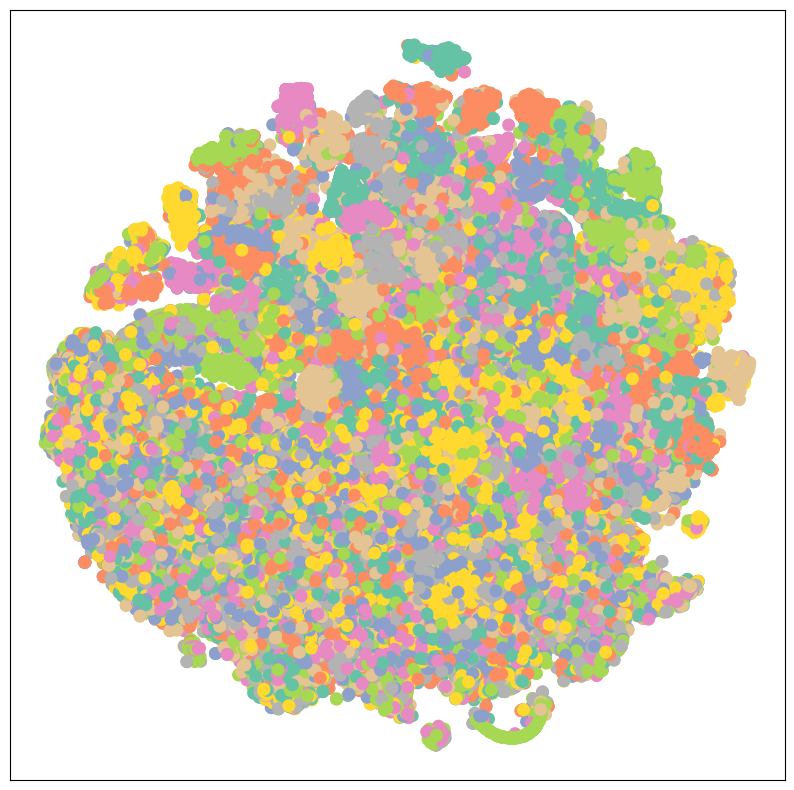

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(256, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 100)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training = self.training)
        x = self.conv2(x, edge_index)
        return x


model = GCN(hidden_channels=128)
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y, result='build')

Epoch 1. Loss = 4.905977725982666
Epoch 2. Loss = 4.5773797035217285
Epoch 3. Loss = 4.314169406890869
Epoch 4. Loss = 4.099843978881836
Epoch 5. Loss = 3.920616626739502
Epoch 6. Loss = 3.7537121772766113
Epoch 7. Loss = 3.616703510284424
Epoch 8. Loss = 3.489616632461548
Epoch 9. Loss = 3.3822593688964844
Epoch 10. Loss = 3.286045789718628
Epoch 11. Loss = 3.205803871154785
Epoch 12. Loss = 3.130565881729126
Epoch 13. Loss = 3.0697107315063477
Epoch 14. Loss = 3.0155107975006104
Epoch 15. Loss = 2.96222186088562
Epoch 16. Loss = 2.9154698848724365
Epoch 17. Loss = 2.8788461685180664
Epoch 18. Loss = 2.840932846069336
Epoch 19. Loss = 2.8061344623565674
Epoch 20. Loss = 2.7724335193634033
Epoch 21. Loss = 2.745973825454712
Epoch 22. Loss = 2.7217230796813965
Epoch 23. Loss = 2.6928133964538574
Epoch 24. Loss = 2.6688108444213867
Epoch 25. Loss = 2.647770643234253
Epoch 26. Loss = 2.632953405380249
Epoch 27. Loss = 2.6150553226470947
Epoch 28. Loss = 2.5952422618865967
Epoch 29. Loss =

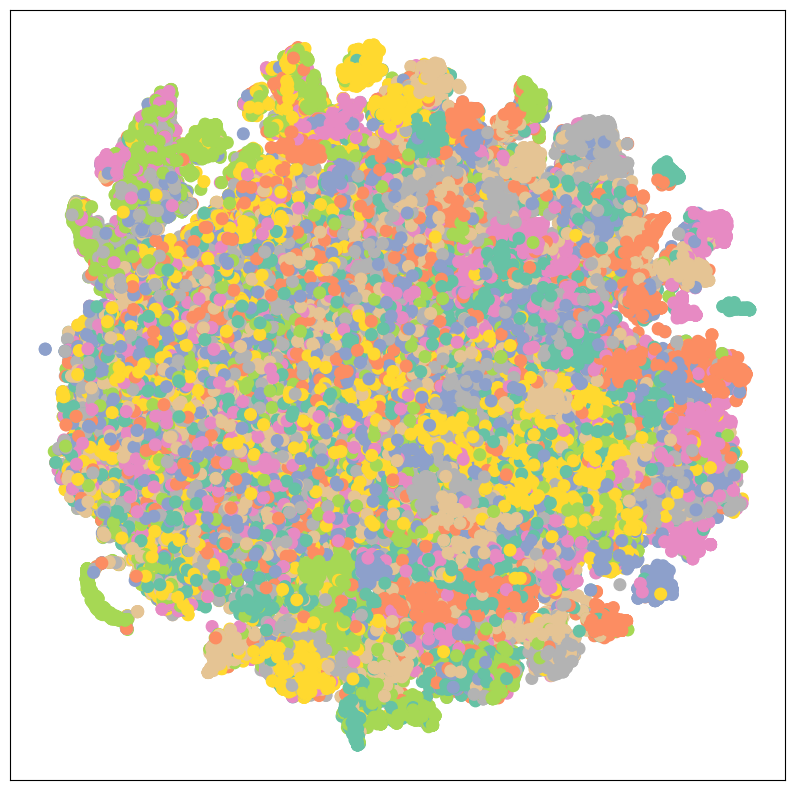

Test Accuracy: 0.7644


In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

in_channels = data.x.shape[1]  # Get the number of features per node
model = GCN(hidden_channels=128)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

# Train the model for 1000 epochs
n_epochs = 2000
for epoch in range(1, n_epochs+1):
    loss = train()
    print("Epoch {}. Loss = {}".format(epoch, loss))

model.eval()
out = model(data.x, data.edge_index)
print(type(out))
visualize(out, color=data.y, result='result')
state_dict = model.state_dict()

with open('/content/drive/MyDrive/weights/gcn_100k_final.h5', 'wb') as file:
    pickle.dump(state_dict, file)

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')